In [2]:
# import importlib
import os
import argparse
import time

from torchvision import datasets
from torchvision import transforms
import torch
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torchvision

import datasets as ds
import models
import utils
from PoseExtraction import PoseNormalization


In [3]:
train_loader, test_loader, dataset_details = ds.birds()

torch.Size([3788, 3, 64, 64])
torch.Size([3788])


In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils

def tensor_to_coord_tensor(X):
    """
    Takes in a 4D image and returns the 3*W*H coordinate representation
    """
    device = X.device
    batch_num, channel_num, height, width = X.shape
    flattened_img = X.permute((0, 1, 3, 2)).contiguous().view(batch_num, -1)
    x_coord = torch.arange(0, width).view(width, 1)
    x_coord = x_coord.expand(width, height).contiguous()
    x_coord = x_coord.view(width * height).float().expand(batch_num, -1).to(device)

    y_coord = torch.arange(height, 0, -1) - 1
    y_coord = y_coord.expand(width, height).contiguous()
    y_coord = y_coord.view(width * height).float().expand(batch_num, -1).to(device)
        
    coord_matrix = torch.stack([x_coord, y_coord, flattened_img])

    return coord_matrix.permute((1, 0, 2))


class KernelCompress(torch.nn.Module):
    def __init__(self, in_channels):
        super(KernelCompress, self).__init__()
        self.conv2d = torch.nn.Conv2d(in_channels, 1, 1)   # hidden layer
        self.conv2d.weight = torch.nn.Parameter(torch.ones(1,in_channels,1,1))
        self.conv2d.bias = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = torch.abs(x)
        x = self.conv2d(x)
        return x

def rot_mat(theta):
    theta = torch.Tensor([theta])
    c, s = torch.cos(theta), torch.sin(theta)
    R = torch.Tensor(((c,-s), (s, c)))
    return R


class PoseNormalization(torch.nn.Module):
    def __init__(self, channel_num, img_shape):
        super(PoseNormalization, self).__init__()
        self.flip_y_loc = torch.Tensor([[2 , 0], [0, -2]])
        self.mu_R = torch.Tensor([0.5, 0.5])
        self.rotate_pi = torch.Tensor([[-1 ,0], [0, 1]])
        self.pi = 3.14159265358979323
        self.theta_R = (self.pi / 2)
        self.channel_compress = KernelCompress(channel_num)   # hidden layer
        self.weights = torch.nn.Parameter(torch.eye(img_shape[1] * img_shape[0]), requires_grad=True)
        # self.weights = torch.nn.Parameter(torch.rand([img_shape[1] * img_shape[0], img_shape[1] * img_shape[0]]), requires_grad=True)
    
    def strength_cofficient(self, L1, L2):
        """
        Measure the relative strength of the first eigen value to the second
        """
        scaling_cofficient = 1
        eig_ratio = (L1 / L2) - 1
        if torch.nonzero(eig_ratio != eig_ratio).shape[0] > 0:
            print("BROKEN EIG VAL:", L1, L2)
            exception = Exception()
            exception.loc = torch.nonzero(eig_ratio != eig_ratio)[0][0]
            raise exception
        confidence = 2*(F.sigmoid(scaling_cofficient * eig_ratio) - 0.5)
        return confidence
    
    def left_svd_tensor(self, T):
        eps = 0.001
        device = T.device
        X = torch.bmm(T, torch.bmm(self.weights.expand(T.shape[0], *self.weights.shape).to(device), T.permute(0, 2, 1)))
        # X = torch.bmm(T, T.permute(0, 2, 1))

        D = X[:, 0, 0]* X[:, 1, 1] - X[:, 0, 1]*X[:, 1, 0]
        D = D.unsqueeze(1).unsqueeze(2)
        X = torch.mul((1 / (D + 0.001)), X)

        T = X[:, 0, 0] + X[:, 1, 1]
        D = X[:, 0, 0]* X[:, 1, 1] - X[:, 0, 1]*X[:, 1, 0]

        L1 = (T + torch.sqrt(F.relu((T**2) - 4*D))) / 2
        L2 = (T - torch.sqrt(F.relu((T**2) - 4*D))) / 2

        v1 = torch.stack([L1 - X[:, 1, 1], X[:, 1, 0]])
        v2 = torch.stack([L2 - X[:, 1, 1], X[:, 1, 0]])
        U = torch.stack([v1, v2]).permute(2, 0, 1)
        U = torch.nn.functional.normalize(U,  dim=2)
        confidence = self.strength_cofficient(L1, L2)
        return U, confidence, L1, L2

    def rot_mat_tensor(self, thetas):
        num_tensors = thetas.shape[0]
        c = torch.cos(thetas).unsqueeze(1).unsqueeze(2)
        s = torch.sin(thetas).unsqueeze(1).unsqueeze(2)
        R = torch.stack([torch.cat([c, -1*s], dim=1),  torch.cat([s, c], dim=1)], dim=1).squeeze(3)
        return R

    def tensor_orientation_transform(self, U, confidence):
        rot_lambda = torch.atan2(U[:, 0, 1], U[:, 0, 0])
        
        theta_R_weighted = rot_lambda + confidence*(self.theta_R - rot_lambda)
        diff_angle = (theta_R_weighted - rot_lambda)

        rotation = self.rot_mat_tensor(diff_angle).float()
        return rotation

    def forward(self, img_tensor):
        epsilon = 0.001
        # try:
        batch_size, channel_num, height, width = img_tensor.shape
        device = img_tensor.device
        img_scale_norm_mat = torch.Tensor([[1 / width , 0], [0, 1 / height]]).to(device)
        compressed_img_tensor = self.channel_compress(img_tensor)


        coord_tensor = tensor_to_coord_tensor(compressed_img_tensor)
        W = torch.abs(coord_tensor[:,2:3,:])
        X = coord_tensor[:, :2, :]
        W3 = F.softmax(W.clone(), dim=2)
        print(W.shape)
        
        WX = torch.mul(W3, X)

        mu_W = (torch.sum(WX, dim=2) / torch.sum(W3, dim=2) + epsilon).unsqueeze(2)

        XC = X - mu_W

        WXC = torch.mul(torch.sqrt(W), XC)

        orientations, confidence, L1, L2 = self.left_svd_tensor(WXC)
        T = self.tensor_orientation_transform(orientations, confidence)


        mu_T = torch.mm(img_scale_norm_mat, mu_W.squeeze(2).t()).t() - self.mu_R.expand(X.shape[0], 2).to(device)
        mu_T = torch.mm(self.flip_y_loc.to(device), mu_T.t()).t().unsqueeze(2)

        theta = torch.cat([T, mu_T], dim=2)

        grid = F.affine_grid(theta, img_tensor.size())
        img_tensor = F.grid_sample(img_tensor, grid)
        # except Exception as exception:
        #     pass
        #     fig, ax = plt.subplots(2, 5, figsize=(50, 20))
        #     for index in range(10):
        #         plot_coords = (index // 5, index % 5)
        #         print(img_tensor[index:index+1].shape)
        #         ax[plot_coords[0], plot_coords[1]].imshow(utils.tensor_to_numpy_img(compressed_img_tensor[index:index+1]))
        #     plt.show()
        return img_tensor, mu_W, orientations, confidence, theta, (L1, L2)

In [80]:
class PreLayerResnet(nn.Module):
    def __init__(self, original_model):
        super(PreLayerResnet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-5])
        
    def forward(self, x):
        x = self.features(x)
        return x
    
class PostLayerResnet(nn.Module):
    def __init__(self, original_model):
        super(PostLayerResnet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[-5:-3])
        
    def forward(self, x):
        x = self.features(x)
        return x

class SVDResnet(nn.Module):
    def __init__(self, original_model, num_classes):
        super(SVDResnet, self).__init__()
        self.pre_resnet = PreLayerResnet(original_model)
        self.post_resnet = PostLayerResnet(original_model)
        self.fc = nn.Linear(4*4*256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pre_resnet(x)
        x = self.post_resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.fc2(x)
        return x

resnet18 = torchvision.models.resnet18()
pre_resnet18 = PreLayerResnet(resnet18)
post_resnet18 = PostLayerResnet(resnet18)
svd_resnet18 = SVDResnet(resnet18, 200)
squeeze = torchvision.models.squeezenet1_0()
sqeeze_inter = squeeze.features[:5]

/usr/local/lib/python3.5/dist-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/usr/local/lib/python3.5/dist-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [81]:
# vgg16 = torchvision.models.vgg16()
for (img, label) in train_loader:
    print(sqeeze_inter(img).shape)
    break

torch.Size([32, 128, 14, 14])


torch.Size([32, 3, 64, 64])
torch.Size([32, 128, 14, 14])
torch.Size([1, 1, 196])
tensor([[[  8.1933],
         [ 10.3753]]])
OUTPUT SHAPE torch.Size([32, 200])
(8.19333553314209, 3.6246938705444336) (0.4283711612224579, -0.9036028981208801)
torch.Size([32, 3, 64, 64])
torch.Size([32, 128, 14, 14])
torch.Size([1, 1, 196])
tensor([[[ 7.0804],
         [ 1.0019]]])
OUTPUT SHAPE torch.Size([32, 200])
(7.080446720123291, 12.998058915138245) (0.14737926423549652, 0.989080011844635)
torch.Size([32, 3, 64, 64])
torch.Size([32, 128, 14, 14])
torch.Size([1, 1, 196])
tensor([[[ 1.5338],
         [ 6.2543]]])
OUTPUT SHAPE torch.Size([32, 200])
(1.5337871313095093, 7.745721817016602) (0.9980407357215881, -0.06256753951311111)
torch.Size([32, 3, 64, 64])
torch.Size([32, 128, 14, 14])
torch.Size([1, 1, 196])
tensor([[[ 4.3767],
         [ 4.4686]]])
OUTPUT SHAPE torch.Size([32, 200])
(4.3766679763793945, 9.531444072723389) (0.6927308440208435, -0.7211962342262268)
torch.Size([32, 3, 64, 64])
torch.S

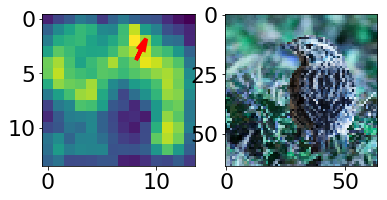

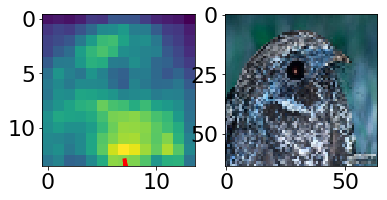

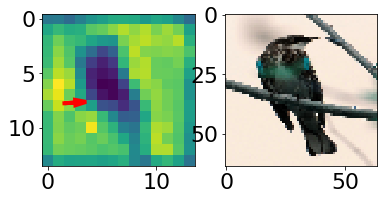

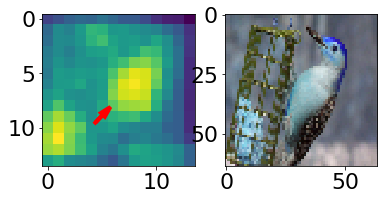

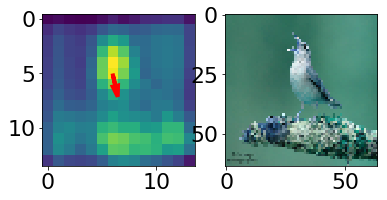

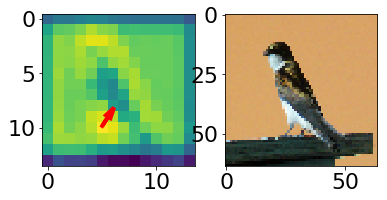

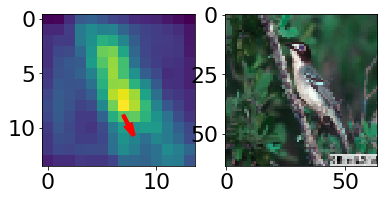

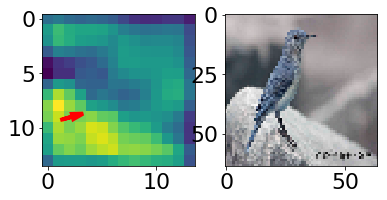

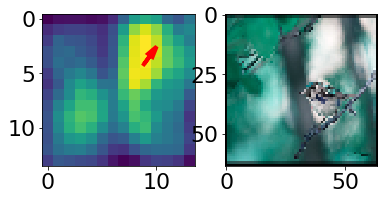

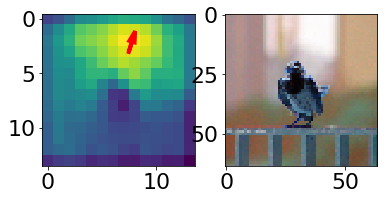

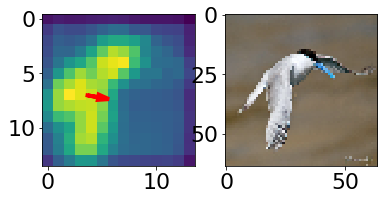

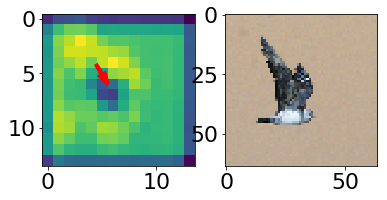

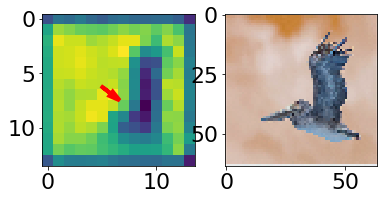

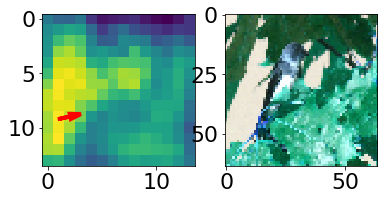

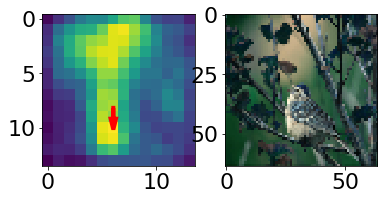

In [83]:
img_shape = (14, 14)
pose_norm = PoseNormalization(channel_num=128, img_shape=img_shape)
for (img, label) in train_loader:
    intermediate = sqeeze_inter(img)
    for index in range(15):
        print(img.shape)
        
        output = svd_resnet18(img)
        print(intermediate.shape)
        flattened = pose_norm.channel_compress(intermediate[index:index+1])
        flattened = flattened / flattened.max()
        _, means, orientations, confidence, theta, (L1, L2) = pose_norm(intermediate[index:index+1])
        print(means)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(utils.tensor_to_numpy_img((flattened)))
        ax[1].imshow(utils.tensor_to_numpy_img(img[index:index+1]))
        print("OUTPUT SHAPE", output.shape)
        

        arrow_scale = 1
        scale = 1

        mean_x = means[0, 0, 0].cpu().data.numpy() * scale
        mean_y = means[0, 1, 0].cpu().data.numpy() * scale

        rot = orientations[0].cpu().data.numpy()
        arrow_start = (mean_x, img_shape[1] - mean_y)
        arrow_end = (rot[0, 0]*arrow_scale, -1*rot[0, 1]*arrow_scale)
        print(arrow_start, arrow_end)

        ax[0].arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
                    head_width=0.5, head_length=1, fc='red', ec='r', linewidth=4, alpha=1)
    break

/home/rees/Code/PoseExtraction/utils.py:89: RuntimeWarning: invalid value encountered in true_divide
  numpy_img /= numpy_img.max()


(-0.5, 13.5, 13.5, -0.5)

/usr/local/lib/python3.5/dist-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/rees/.local/lib/python3.5/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


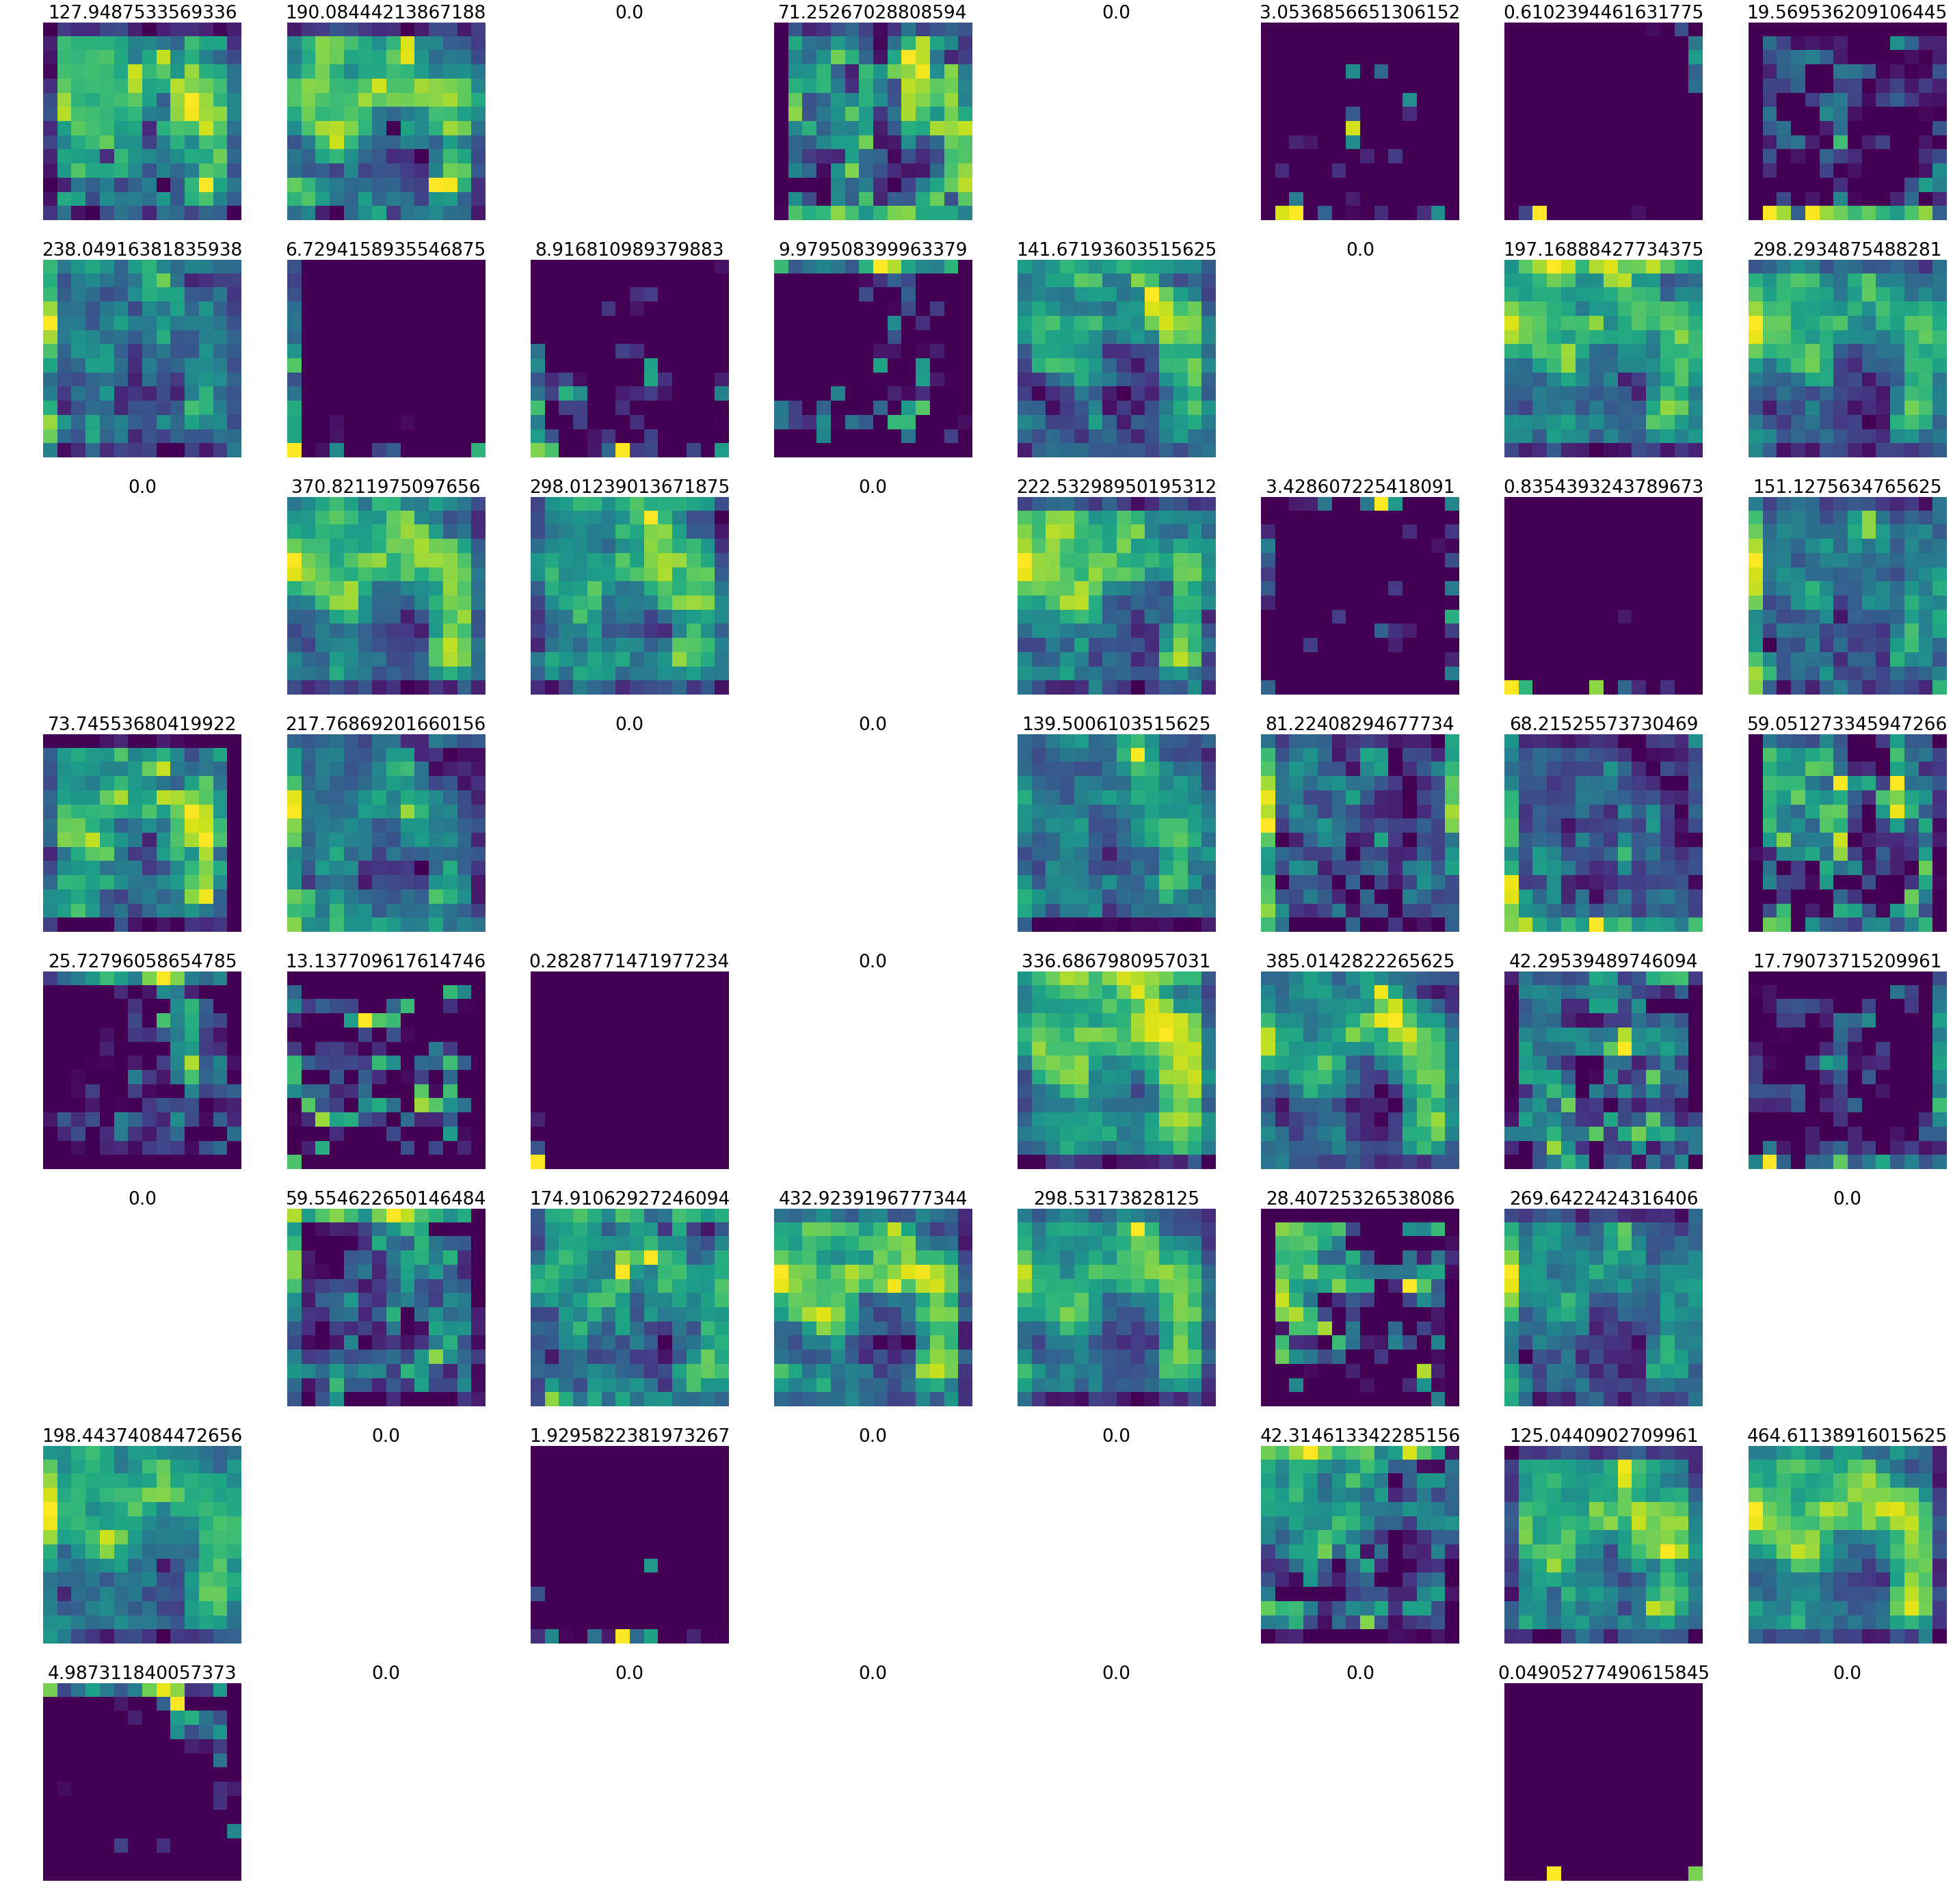

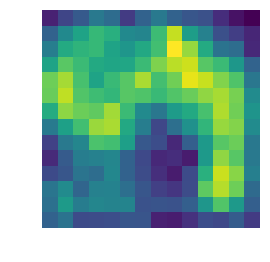

In [86]:
index = 0
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(8, 8, figsize=(50, 50))
flattened = pose_norm.channel_compress(intermediate[index:index+1])
for index2 in range(64):
    current_tensor = intermediate[index:index+1, index2:index2+1]
    max_val = current_tensor.sum()
    ax[index2 % 8, index2 // 8].imshow(utils.tensor_to_numpy_img(current_tensor))
    ax[index2 % 8, index2 // 8].set_title(max_val.item())
    ax[index2 % 8, index2 // 8].axis('off')
    
fig2, ax2 = plt.subplots()
ax2.imshow(utils.tensor_to_numpy_img(flattened))
ax2.axis('off')